In [1]:
import logging
import warnings
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Functionals as FUNC
import TransportMaps.Maps as MAPS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
warnings.simplefilter("ignore")
TM.setLogLevel(logging.INFO)

x_tm = np.linspace(-4,4,100).reshape((100,1))
def plot_mapping(tar_star, Tstar, tar=None, T=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_twx = ax.twinx()
    ax_twy = ax.twiny()
    ax.plot(x_tm, Tstar(x_tm), 'k-', label=r"$T^\star$") # Map
    n01, = ax_twx.plot(x_tm, stats.norm(0.,1.).pdf(x_tm), '-b') # N(0,1)
    g, = ax_twy.plot(tar_star.pdf(Tstar(x_tm)), Tstar(x_tm), '-r') # Gumbel
    if T is not None:
        ax.plot(x_tm, T(x_tm), 'k--', label=r"$\hat{T}$") # Map
    if tar is not None:
        ax_twy.plot(tar.pdf(Tstar(x_tm)), Tstar(x_tm), '--r') # Gumbel
    ax.set_ylabel(r"Map")
    ax_twx.set_ylabel('N(0,1)')
    ax_twx.yaxis.label.set_color(n01.get_color())
    ax_twy.set_xlabel('Target PDF')
    ax_twy.xaxis.label.set_color(g.get_color())
    ax.legend(loc = (0.1, 0.8))
    
import TransportMaps.Distributions as DIST
from GaussianPosterior import *
from scipy.special import erfinv
        
sigma = .1
mean = np.random.uniform(size=(1,))
dist = GaussianPosterior(noise=sigma, y_measurement=mean)

class GaussianPosteriorDistribution(DIST.Distribution):
    def __init__(self):
        super(GaussianPosteriorDistribution,self).__init__(1)
        self.sigma = sigma
        self.mean = mean
    def pdf(self, x, params=None, *args, **kwargs) :
        if not hasattr(x, '__len__') : x = [x]
        return np.array([dist.Evaluate([np.array([xi])])[0][0]/self.sigma/np.sqrt(2*np.pi) for xi in x])
    def log_pdf(self, x, params=None, *args, **kwargs):
        return - ((x.reshape((x.shape[0],))-self.mean)/self.sigma)**2/2 - np.log(self.sigma*np.sqrt(2*np.pi))
    def grad_x_log_pdf(self, x, params=None, *args, **kwargs):
        return - (x - self.mean) / self.sigma**2
    def hess_x_log_pdf(self, x, params=None, *args, **kwargs):
        return np.array([- 1 / self.sigma**2])[:,np.newaxis,np.newaxis]
    
class GaussianPosteriorTransportMap(object):
    def __init__(self, pi):
        self.sigma = pi.sigma
        self.mean = pi.mean
        self.ref = stats.norm(0.,1.)
    def evaluate(self, x, params=None):
        if isinstance(x,float):
            x = np.array([[x]])
        if x.ndim == 1:
            x = x[:,NAX]
        out = self.mean + self.sigma * np.sqrt(2) * erfinv(2*self.ref.cdf(x) - 1)
        return out
    def __call__(self, x):
        return self.evaluate(x)

pi = GaussianPosteriorDistribution()
Tstar = GaussianPosteriorTransportMap(pi)

/usr/lib/python3.9/site-packages/TransportMaps-2.0b3-py3.9.egg/TransportMaps/External.py:35: UserWarning: MPI support disabled: install mpi4py and mpi_map if needed.
  warnings.warn("MPI support disabled: install mpi4py and mpi_map if needed.")
/usr/lib/python3.9/site-packages/TransportMaps-2.0b3-py3.9.egg/TransportMaps/External.py:54: UserWarning: H5 file support disabled: install h5py if needed.
  warnings.warn("H5 file support disabled: install h5py if needed.")
/usr/lib/python3.9/site-packages/TransportMaps-2.0b3-py3.9.egg/TransportMaps/External.py:63: UserWarning: pyhmc is not supported: install pyhmc if needed.
  warnings.warn("pyhmc is not supported: install pyhmc if needed.")


### PDF of the target distribution

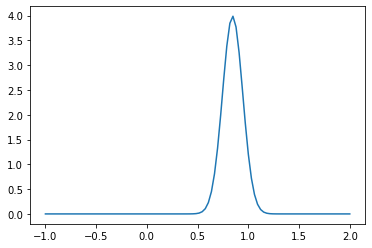

In [2]:
x = np.linspace(-1., 2., 100).reshape((100,1))
plt.figure()
plt.plot(x, pi.pdf(x));

### Exact transport map $T^\star$

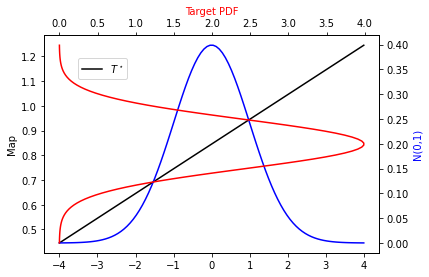

In [3]:
plot_mapping(pi, Tstar)

## Laplace approximation

The Laplace approximation consists in the fit of a Gaussian distribution $\tilde{\pi} \sim \mathcal{N}(\mu, \Sigma)$ to the target $\pi$, where we select the mean to be (one of) the mode(s) of the distribution

$$ \mu = \arg\max_{x} \log \pi(x) $$
    
and $\Sigma^{-1} = -\nabla^2 \log \pi(\mu)$. Then the linear transport map that pushes forward the reference distribution $\rho \sim \mathcal{N}({\bf 0},{\bf I})$ to the approximation $\tilde{\pi}$ of $\pi$ ($L_{\sharp} \rho = \tilde{\pi} \approx \pi$) is given by

$$ L({\bf x}) = \mu + \Sigma^{1/2} {\bf x} \;. $$

In [4]:
laplace_approx = TM.laplace_approximation(pi)
L = MAPS.LinearTransportMap.build_from_Gaussian(laplace_approx)
rho = DIST.StandardNormalDistribution(1)
approx_pi = DIST.PushForwardTransportMapDistribution(L, rho)

2021-01-04 15:36:00 INFO:TM.TransportMaps: Optimization terminated successfully
2021-01-04 15:36:00 INFO:TM.TransportMaps:   Function value:          -1.383647
2021-01-04 15:36:00 INFO:TM.TransportMaps:   Norm of the Jacobian:    0.000000
2021-01-04 15:36:00 INFO:TM.TransportMaps:   Number of iterations:         2
2021-01-04 15:36:00 INFO:TM.TransportMaps:   N. function evaluations:      2
2021-01-04 15:36:00 INFO:TM.TransportMaps:   N. Jacobian evaluations:      2
2021-01-04 15:36:00 INFO:TM.TransportMaps:   N. Hessian evaluations:       2


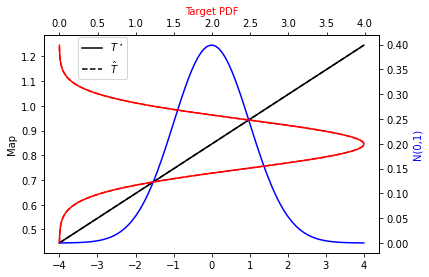

In [5]:
plot_mapping(pi, Tstar, approx_pi, L)

## Linear span parametrization

The linear span parametrization takes the simple form:

$$ T_k({\bf a},{\bf x}) = \Phi({\bf x}) {\bf a}\;, \qquad \text{for}\; {\bf x}=\{x_1,\ldots,x_k\} $$

A 3-rd order polynomial approximation can be built using the following code:

In [6]:
Tk = FUNC.MonotonicLinearSpanApproximation([ S1D.HermiteProbabilistsPolynomial() ], # list of one dimensional basis. Since $d=1$ the list contains only one element
                                           spantype='full',                         # polynomial order for each dimension
                                           order_list=[ 3 ])

T = MAPS.MonotonicLinearSpanTriangularTransportMap([[0]], # Element `i` of this list states which are the active variables for approximation $T_i$. In this $T_1$ depends only on $x_1$ (in python counting, variable `0`)
                                                   [Tk])  # `Tk` is the approximation $T_1$, the approximations $T_1,\ldots,T_d$ are collected into a list 

# Alternatively, one can use the default constructor:
# T = TM.Default_IsotropicMonotonicLinearSpanTriangularTransportMap(1, order, 'full')

Recall that the set $\mathcal{T}_\triangle$ contains all the lower triangular maps monotonic in their last variable. Unfortunately when we restric our attention to the set $\mathcal{P}_\triangle$, the lower triangular polynomial maps, the approximation is not monotonic in general. Monotonicity needs to be enforced. This is done locally at the sampling points used to approximate the KL-divergence. To see how this is done, we need to explain how the optimization problem is actually formulated. 

Note that

$$ \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \middle\Vert \nu_\pi \right) 
= \mathbb{E}_{\rho}\left[ -\log T^\sharp \pi \right] + \mathbb{E}_{\rho}\left[ \log \rho \right] $$

where the last term is the *entropy* of $\rho$ and does not depend on the transport map.

The expectation $\mathbb{E}_{\rho}$ will be in general approximated using quadratures $\{{\bf x}_i,w_i\}_{i=1}^M$, leading to the optimization problem

$$ \hat{T} = \arg\min_{T \in \mathcal{T}_\triangle} \sum_{i=1}^M w_i \left[ -\log T^\sharp \pi({\bf x}_i) \right] $$

Focusing on lower triangular polynomial approximations $\mathcal{P}_\triangle$, we obtain the following **constrained** optimization problem:

$$ \hat{T} = \arg\min_{\hat{T} \in \mathcal{P}_\triangle} \sum_{i=1}^M w_i \left[ -\log T^\sharp \pi({\bf x}_i) \right] \;, $$
$$\text{s.t.}\;\partial_{x_k} T_k({\bf x}_i) \geq 0 \;, \quad \forall i\in\{1,\ldots,M\}$$

All these details are accounted for inside the `TransportMaps` implementation, which will detect the need to reformulate the problem accordingly when it encounters lower triangular polynomial approximations.

In [7]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
log = push_rho.minimize_kl_divergence(pi, 
                                      qtype=3,             # Gauss quadrature
                                      qparams=[20],        # Quadrature order
                                      regularization=None, # No regularization
                                      tol=1e-10,           # Optimization tolerance
                                      ders=1)              # Use gradient / One could also solve the problem without using gradient information (e.g., if not available). The optimizer would in this case resort to gradient free solvers.

2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence:   Function value:          1.418939
2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000058
2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        10
2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     19
2021-01-04 15:36:01 INFO: TM.MonotonicLinearSpanTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     10


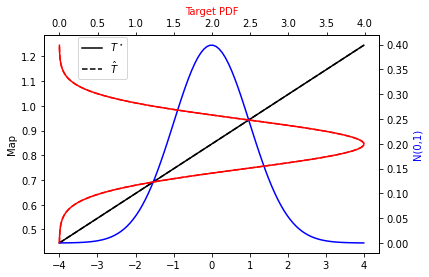

In [8]:
plot_mapping(pi, Tstar, push_rho, T)

## Integrated exponential parametrization

This parameterization takes the form:

$$ T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \exp\left( h({\bf a}_e;x_1,\ldots,x_{k-1},t) \right) dt \;,$$

where $c$ and $h$ are themselves two parametric approximations. We use polynomial approximations for both of these functions, such that:

$$ c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.$$

In general we will require the approximation $c$ to be constant in $x_d$ and this is achieved using a zero's order approximation in the $x_d$ dimension of $c$. 

A 3-rd order approximation of the transport map is then built:

In [9]:
c_approx = FUNC.MonotonicLinearSpanApproximation([S1D.HermiteProbabilistsPolynomial()], 
                                                 spantype='full', 
                                                 order_list=[0])
e_approx = FUNC.MonotonicLinearSpanApproximation([S1D.ConstantExtendedHermiteProbabilistsFunction()], 
                                                 spantype='full', 
                                                 order_list=[3])

Tk = FUNC.MonotonicIntegratedExponentialApproximation(c_approx, e_approx)

T = MAPS.IntegratedExponentialTriangularTransportMap([[0]], [Tk])

# Alternatively, one can use the default constructor:
# T = TM.Default_IsotropicIntegratedExponentialTriangularTransportMap(1, order, 'full')

In [10]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
log = push_rho.minimize_kl_divergence(pi, 
                                      qtype=3,             # Gauss quadrature
                                      qparams=[20],        # Quadrature order
                                      regularization=None, # No regularization
                                      tol=1e-10,           # Optimization tolerance
                                      ders=2)              # Use gradient and Hessian 

2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Function value:          1.418939
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000000
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        15
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     15
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     15
2021-01-04 15:36:02 INFO: TM.IntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations:      15


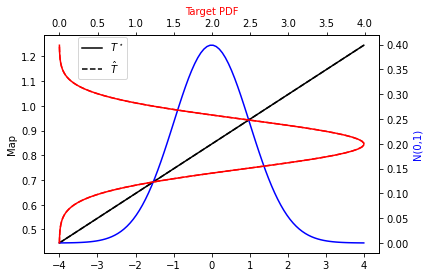

In [11]:
plot_mapping(pi, Tstar, push_rho, T)

## Integrated squared parametrization

This parameterization takes the form:

$$ T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \left( h\left({\bf a}_e;x_1,\ldots,x_{k-1},t \right) \right)^2 \, dt \;,$$

where $c$ and $h$ are themselves two parametric approximations. We use polynomial approximations for both of these functions, such that:

$$ c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.$$

The advantage of using this parametrization, with Hermite polynomials for $c({\bf a}_c,{\bf x})$ and constant extended Hermite functions (see ``SpectralToolbox`` documentation) for $h({\bf a}_e,{\bf x})$, is that the integration can be performed analytically, rather than numerically.
In general we will require the approximation $c$ to be constant in $x_d$ and this is achieved using a zero's order approximation in the $x_d$ dimension of $c$.

 We construct a 3-rd order approximation with the following code:

In [12]:
Tk = FUNC.MonotonicIntegratedSquaredApproximation(c_approx, e_approx)
T = MAPS.IntegratedSquaredTriangularTransportMap([[0]], [Tk])

# Alternatively, one can use the default constructor:
# T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(1, order, 'full')

In [13]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
log = push_rho.minimize_kl_divergence(pi, 
                                      qtype=3,             # Gauss quadrature
                                      qparams=[20],        # Quadrature order
                                      regularization=None, # No regularization
                                      tol=1e-10,           # Optimization tolerance
                                      ders=2)              # Use gradient and Hessian 

2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Function value:          1.418939
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000000
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        12
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     12
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     12
2021-01-04 15:36:03 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations:      12


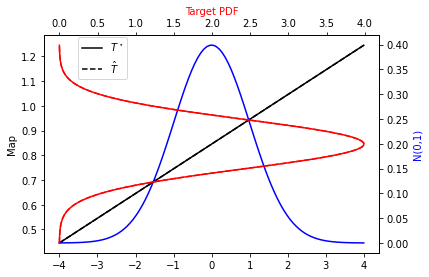

In [14]:
plot_mapping(pi, Tstar, push_rho, T)

## Sampling from the approximation
One of the strength of the transport map approach is that once the map $\hat{T}$ is constructed, sampling from $\hat{T}_\sharp \nu_\rho \approx \nu_\pi$ becomes a trivial and computationally cheap task. In fact, 

$$ \{{\bf x}_i\}_{i=1}^M \sim \rho  \qquad \Rightarrow \qquad  \{\hat{T}({\bf x}_i)\}_{i=1}^M \sim \hat{T}_\sharp \nu_\rho \approx \nu_\pi$$

This process is hidden to the user, who can directly handle the object $\hat{T}_\sharp \nu_\rho$.

### Monte-Carlo sampling

[[0.84372183]
 [0.86464692]
 [0.89356639]
 ...
 [0.8441668 ]
 [0.93867758]
 [0.90405976]]


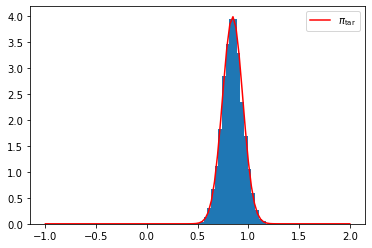

In [15]:
M = 10000
samples = push_rho.rvs(M)
print(samples)
plt.figure()
plt.hist(samples,bins=20,density=True);
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.legend();

### Gauss quadratures

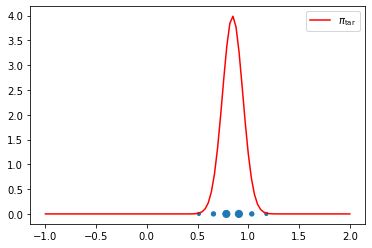

In [16]:
M = 5
(xq,wq) = push_rho.quadrature(qtype=3, qparams=[M])
plt.figure()
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.scatter(xq, np.zeros(len(xq)), s=100*wq+10.);
plt.legend();

The approximation of higher order quadrature rules require the construction of higher order approximations. Let us try to construct a 10-th order quadrature rule using a 10-th order integrated exponential approximation.

2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Function value:          1.418939
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000000
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        14
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     14
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     14
2021-01-04 15:36:05 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations:      14


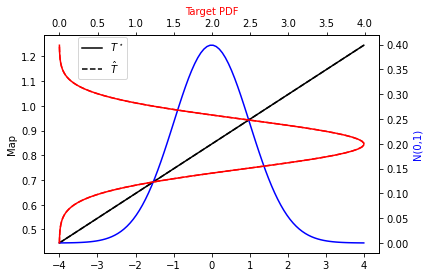

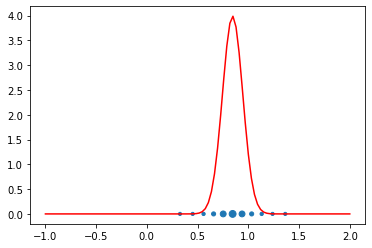

In [17]:
order = 10
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(1, order, 'full')
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

plot_mapping(pi, Tstar, push_rho, T)

M = 10
(xq,wq) = push_rho.quadrature(qtype=3, qparams=[M])
plt.figure()
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.scatter(xq, np.zeros(len(xq)), s=100*wq+10.);

## Accuracy diagnostics

The estimation of the accuracy of the approximation $\hat{T}_\sharp \nu_\rho$ of $\nu_\pi$ is a fundamental feature deriving from the fact that we are not only computing a density approximation, but also a transport attaining this approximation.

### Variance diagnostic

As shown in [[TM1]](aa-references.html#elmoselhy2012), as $\mathcal{D}_{\rm KL}\left(T_\sharp \nu_\rho \middle\Vert \nu_\pi\right) \rightarrow 0$ (i.e. as $T\rightarrow T^\star$), the following hold:

$$ \mathcal{D}_{\rm KL}\left(T_\sharp \nu_\rho \middle\Vert \nu_\pi\right) \approx \frac{1}{2} \mathbb{V}{\rm ar}_\rho\left[ \log \frac{\rho}{T^\sharp \pi} \right] $$

This diagnostic can be easily computed using the following code:

In [18]:
import TransportMaps.Diagnostics as DIAG
pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
var = DIAG.variance_approx_kl(rho, pull_pi, qtype=3, qparams=[20])
print("Variance diagnostic: %e" % var)

Variance diagnostic: 2.227431e-11


Let us then look at how this quantity behaves as we increase the order of the approximation.

In [19]:
def plot_var_diag():
    var_list = []
    ord_list = list(range(1,10))
    for order in ord_list:
        T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
            1, order, 'full')
        push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
        log = push_rho.minimize_kl_divergence(
            pi, qtype=qtype, qparams=qparams,
            regularization=reg, tol=tol, ders=ders)
        pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
        v = DIAG.variance_approx_kl(rho, pull_pi, qtype=3, qparams=[20])
        var_list.append(v)
    plt.figure()
    plt.semilogy(ord_list, var_list, '-o');
    plt.grid();
    plt.xlabel('Order');
    plt.ylabel('Variance diagnostic');

2021-01-04 15:36:09 WARNING: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Minimization of KL-divergence failed.
2021-01-04 15:36:09 WARNING: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Message: Warning: Desired error not necessarily achieved due to precision loss.


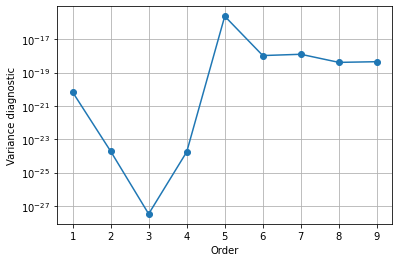

In [20]:
TM.setLogLevel(logging.WARNING)
plot_var_diag()